<h1><b>Statistique en Bioinformatique : </b> TME8 </h1><br>

L’objectif de ce TME est: 
<br>
<ul>
<li> Evaluer la performance des HMMs sur les homologues lointains </li> 
</ul>
<br>
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p><b>Soumission</b></p>
<ul>
<li>Renomer le fichier TME8.ipynb pour NomEtudiant1_NomEtudiant2.ipynb </li>
<li>Soumettre via moodle </li>
</div>
</div>


<h2> Datasets </h2><br>
To evaluate the performance of HMMer over remote homologous proteins, we will work with datasets scop-95 and scop-30 having at most 95 and 30% of sequence identity, respectivelly.  We will use a leave-one-out strategy as follows. Given a scop family $F$ in one of the scop datasets, we consider the set of $n$ sequences associated to $F$, to create $n$ test-sets for $F$. Each test-set takes $n−1$ sequences for training and leaves one sequence out for the test. Then, we test whether the sequence that was left out could be annotated by a HMMer profile constructed without using it, and count the correct identification of the domain as a true positive (TP), the identification of an erroneous domain as a false positive (FP) and the identification of no domain as a false negative (FN). For each scop dataset you can find the directory `aln` that contains the alignment for each testsets in STOCKHOLM format, extension .sto

For scop-95 dataset do:

1\. Create pHMMs from the alignments in `aln/*.sto`. Use the program `hmmbuild` from the HMMer-3 package. Save models  in a directory named models. You have two options (1) do your script in python or (2) in bash script and run it in the terminal.
To  built models with python you can use `os.system` to execute hmmbuild program.
Anyway, put your code bellow.

In [1]:
import numpy as np
import os
from os import listdir,system,makedirs
from os.path import isfile,join,exists
from shutil import rmtree
import matplotlib.pyplot as plt


In [ ]:
#see run.sh
!./run.sh


2\. Search all sequences in the file `scopTestSeq.fasta` against all models created previously. Use `hmmsearch` and the option `--domtblout` to save parseable table of per-domain hits to file, use option `-E 1`. Save the outputs in a directory named `searchResults/`. You have two options (1) do your script in python or (2) in bash script and run it in the terminal.
To  built models with python you can use `os.system` to execute hmmsearch program.
Anyway, put your code bellow.

In [ ]:
#see search.sh
!./search.sh


3\. Concat all search results, rank the sequences and remove all hits having same family and different proteinID. Consider just the best hit per sequence.

```bash
# the following bash commands illustrate a way to concatenate and format the output of hmmsearch
# hmmsearch results are assumed to be in the current directory and in files with extension .out
cat *.out > allRes.txt
sed '/^#/d' allRes.txt > allRes.txt.ftt
cat allRes.txt.ftt | awk '{print $1" "$4" "$12}' > allRes.txt.ftt.2
sed -i -e 's/\.aln//g' allRes.txt.ftt.2
mv allRes.txt.ftt.2 allRes.txt.ftt
```

In [2]:
#Filter the best hit for each test sequence, you can produce a table with
#sequenceID, correct family, predicted family

def removeWrongLines(nom):
	infile=open(nom, 'r')
	outfile=open(nom + ".tmp", 'w')
	A=infile.readlines()
	rep = ""
	cpt=0
	for ligne in A :
		if ligne[0] != "#":
			tab=ligne.split()
			prot = tab[0]; protqid = prot[0:7]; protqfa = prot[7:]
			prot = tab[1]; protmid = prot[0:7]; protmfa = prot[7:]
			if (protqfa != protmfa) :
				rep= rep + ligne
			elif (protqid == protmid):
				rep= rep + ligne

	outfile.write(rep)
	outfile.close()
	infile.close()

################################################
def removeDupLines(nom):
	infile=open(nom, 'r')
	A=infile.readlines()
	rep = {}
	lrep = []
	cpt=0
	for ligne in A :
		tab=ligne.split()
		prot = tab[0]; protqid = prot[0:7]; protqfa = prot[7:]
		prot = tab[1]; protmid = prot[0:7]; protmfa = prot[7:]
		evalue = float(tab[2])
		l=[]
		if protqid not in rep.keys():
			l.append(protqid); l.append(protqfa); l.append(protmid); l.append(protmfa); l.append(evalue);
		else:
			c = rep[protqid]
			#print c
			if (evalue < c[4]):
				l.append(protqid);l.append(protqfa); l.append(protmid); l.append(protmfa); l.append(evalue);
			else:
				l = c
		rep[protqid] = l

	for key in rep:
		lrep.append(rep[key])
	return lrep

file = "searchResults95/allRes.txt.ftt"
removeWrongLines(file)
rep = removeDupLines(file + ".tmp")


4\. Compute the performance. If a test sequence is better scored by the model associated to its family it is a true positive (TP). If it is scored by a different model it is a false positive (FP). If it is not scored by any model it is a false negative (FN). With this values compute $\text{Precision}=\frac{TP}{TP+FP}$, $\text{Recall} = \frac{TP}{TP+FN}$, and $\text{F-score} = \frac{ 2 \cdot \text{Precision} \cdot \text{Recall} }{ \text{Precision} + \text{Recall} }$.

In [3]:
import pandas as pd

def ComputePerformance(resultsTable):
    """
    compute performance measures
    """

    table = pd.DataFrame(resultsTable, columns=['target_sequence', 'target_family', 'query_sequence', 'query_family', 'score'])

    tp = (table.target_family == table.query_family).sum()
    fp = len(table) - tp
    fn = 789 - len(table)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2*precision*recall / (precision+recall)

    return tp, fp, fn, precision, recall, f_score


TP,FP,FN,precision,recall,f_score = ComputePerformance(rep)


5\. Roc curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. We can plot curves to observe the performance of a tool under different conditions. For that, we range the score (E-value) and we compute true positive rate (Y axis) and false positive rate (X-axis) measures for each value. Write a python script to construct the Roc curve based on the results obtained before.<br><br>

<font color="blue">
Sensitivity = true positive rate, recall, or probability of detection = the proportion of positives that are correctly classified
Specificity = true negative rate = the proportion of negatives that are correctly classified
<br>
<br>
$\text{True Positive Rate} = \frac{TP}{TP+FN}$
<br>
<br>
$\text{False Positive Rate} = \frac{FP}{FP+TN}$
<font>

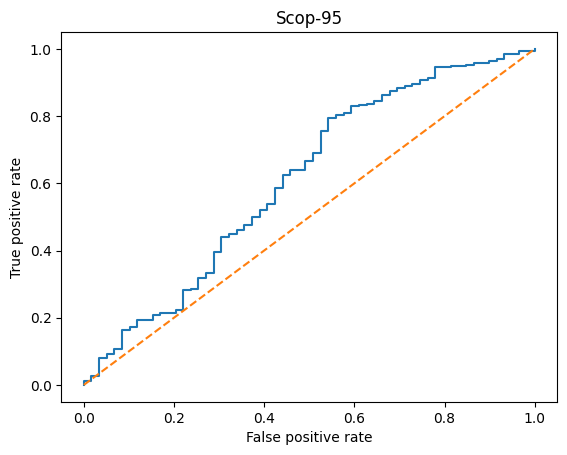

In [4]:
def plotROC(rep, nom, total):
  table = pd.DataFrame(rep, columns=['target_sequence', 'target_family', 'query_sequence', 'query_family', 'score'])
  table.sort_values(by='score', inplace=True)

  tps = np.array([0, *(table.target_family == table.query_family).cumsum()])
  fps = np.array([0, *(table.target_family != table.query_family).cumsum()])

  tps = tps / tps[-1]
  fps = fps / fps[-1]

  fig, ax = plt.subplots()

  ax.plot(fps, tps)
  ax.plot([0, 1], [0, 1], linestyle='--')

  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.set_title(nom)


plotROC(rep, "Scop-95", 789)


6\. Write a python script to plot the Precision/recall curve. We can use the same strategy of Roc curve to compute the precision  (Y axis)  and recall  (X axis)  curves.

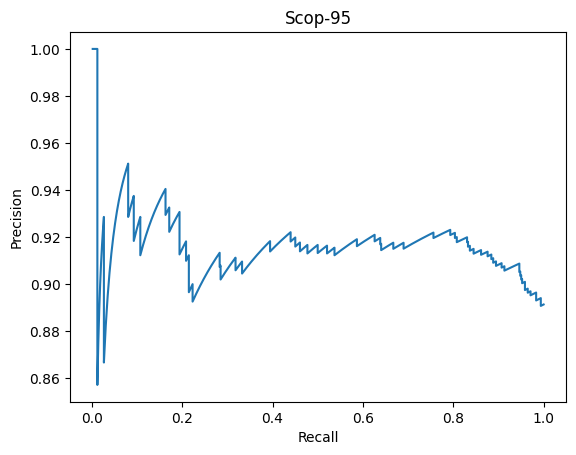

In [5]:
def plotPR(reps, nom, total):
  table = pd.DataFrame(reps, columns=['target_sequence', 'target_family', 'query_sequence', 'query_family', 'score'])
  table.sort_values(by='score', inplace=True)

  tps = np.array(table.target_family == table.query_family).cumsum()
  fps = np.array(table.target_family != table.query_family).cumsum()
  fns = -tps + tps[-1]

  precision = tps / (tps + fps)
  recall = tps / (tps + fns)

  fig, ax = plt.subplots()

  ax.plot(recall, precision)
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_title(nom)


plotPR(rep, "Scop-95", 789)


7\. Repeat steps 1 to 6 also for the scop-30 dataset and compare the curves obtained for the two SCOP datasets, what is your conclusion? Include the curves in your answer.



In [ ]:
!./run2.sh


In [ ]:
!./search2.sh


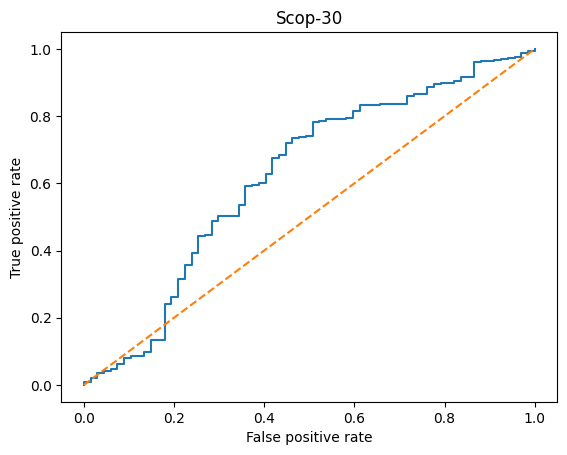

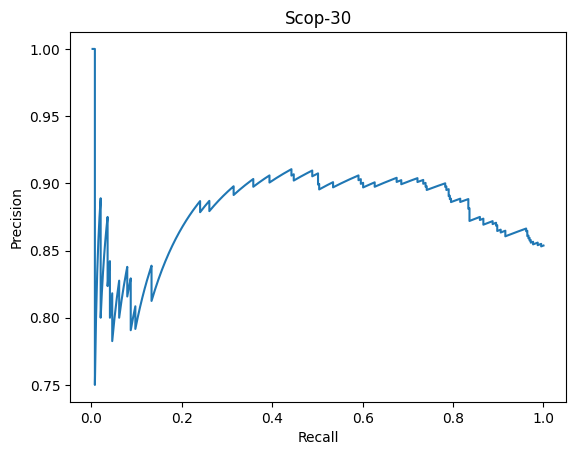

In [9]:
file = "searchResults30/allRes.txt.ftt"
removeWrongLines(file)
rep = removeDupLines(file + ".tmp")

TP,FP,FN,precision,recall,f_score = ComputePerformance(rep)
plotROC(rep, "Scop-30", 789)
plotPR(rep, "Scop-30", 789)


Conclusion :
<font color="blue">
La courbe ROC est légèrement meilleure pour Scop-30, on préfèrera donc utiliser le dataset Scop-30 pour la détection d'homologue, avec un seuil à déterminer grâce aux courbes.
<font>